In [26]:
import pandas as pd
import numpy as np
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.utils import resample
from IPython.display import display, HTML
from scipy import stats
import statsmodels.formula.api as smf
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# Load data from CSV files
data = pd.read_csv("/path/to/your/directory/N.2012_ONLY.csv")
income_df = pd.read_csv("/path/to/your/directory/N.covariates.csv", low_memory=False)

# Drop unnecessary columns
data.drop(['hid_x', 'health'], axis=1, inplace=True)

In [21]:
# analysis of CATE estimates as a % of the baseline mean income

# Filter the 2011 data from the main dataframe
data_2011 = data[data['syear'] == 2011]

# Filter the 2016 income data from income_df
income_2016 = income_df[income_df['syear'] == 2016][['pid', 'gross_income']]

# Merge the 2016 income data with the 2011 data based on 'pid'
merged_data = pd.merge(data_2011, income_2016, on='pid', how='inner', suffixes=('_2011', '_2013'))

# Define covariates, treatment, and outcome
X = merged_data[['sex', 'age_at_survey', 'education', 'hhgr' ,'gross_income_2011', 'lf_status']]
T = merged_data['binary_treatment']
y = merged_data['gross_income_2013']

# Drop rows with any missing values
merged_data_clean = merged_data.dropna(subset=['sex', 'age_at_survey', 'education','hhgr', 'gross_income_2011', 'lf_status', 'binary_treatment', 'gross_income_2013'])

# Redefine X, T, y after dropping NaNs
X_clean = merged_data_clean[['sex', 'age_at_survey', 'education', 'hhgr' ,'gross_income_2011', 'lf_status']]
T_clean = merged_data_clean['binary_treatment']
y_clean = merged_data_clean['gross_income_2013']

# Define the models for the outcome and propensity score estimation
outcome_learner = GradientBoostingRegressor(n_estimators=100, random_state=42)
propensity_learner = LogisticRegression(random_state=42)

# Instantiate the X-Learner
x_learner = XLearner(models=outcome_learner, propensity_model=propensity_learner)

# Fit the X-Learner
x_learner.fit(y_clean, T_clean, X=X_clean)

# Estimate the Conditional Average Treatment Effect (CATE) for the entire dataset
cate_estimates = x_learner.effect(X_clean)

# Calculate the baseline mean income for 2011
baseline_mean_income = merged_data_clean['gross_income_2011'].mean()

# Scale the CATE estimates by this baseline mean income
cate_estimates_scaled = cate_estimates / baseline_mean_income

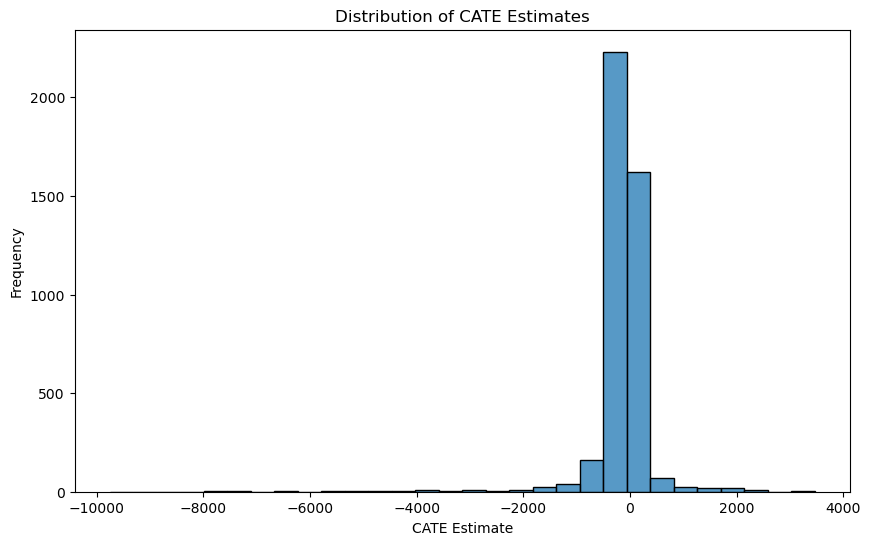

In [4]:
# Histogram of CATE estimates
plt.figure(figsize=(10, 6))
sns.histplot(cate_estimates, bins=30)
plt.title('Distribution of CATE Estimates')
plt.xlabel('CATE Estimate')
plt.ylabel('Frequency')
plt.show()


In [10]:
# defining subgroups based on age, education, and household size

# Step 1: Create Age Groups (with ranges suitable for your data)
age_bins = [18, 26, 36, 46, 56, 67]  # Adjusting age bins based on the range 18-66
age_labels = ['18-25', '26-35', '36-45', '46-55', '56-66']
merged_data_clean.loc[:,'age_group'] = pd.cut(merged_data_clean['age_at_survey'], bins=age_bins, labels=age_labels, right=False)

# Define education bins and labels
education_bins = [6, 10, 12, 15, 18]  # Bins: 7-10, 11-12, 13-15, 16-18
education_labels = ['7-10', '11-12', '13-15', '16-18']
merged_data_clean.loc[:,'education_group'] = pd.cut(merged_data_clean['education'], bins=education_bins, labels=education_labels, right=False)

# Define household size (hhgr) bins and labels
hhgr_bins = [0, 1, 2, 4, 12]  # Bins: 1, 2, 3-4, 5-12
hhgr_labels = ['1', '2', '3-4', '5-12']
merged_data_clean.loc[:,'hhgr_group'] = pd.cut(merged_data_clean['hhgr'], bins=hhgr_bins, labels=hhgr_labels, right=False)

# Step 3: Append CATE Estimates to the DataFrame
merged_data_clean.loc[:,'cate_estimates_scaled'] = cate_estimates_scaled

In [11]:
# Interaction between Age and Education (CATE estimates for income)

# Summary for Education by Age Group
summary_edu_age = merged_data_clean.pivot_table(
    index='education_group', 
    columns='age_group', 
    values='cate_estimates_scaled', 
    aggfunc=['mean', 'count', np.std]
)

# Calculate standard errors by dividing std by the square root of the count for each cell
for col in summary_edu_age.columns.levels[1]:
    summary_edu_age[('std_err', col)] = summary_edu_age[('std', col)] / np.sqrt(summary_edu_age[('count', col)])

# Flatten the MultiIndex columns
summary_edu_age.columns = [f"{col[1]}_{col[0]}" for col in summary_edu_age.columns]

# Display the result
print("Summary of CATE Estimates, Standard Errors, and Sample Sizes for Education by Age Group")

display(HTML(summary_edu_age.to_html()))


Summary of CATE Estimates, Standard Errors, and Sample Sizes for Education by Age Group


,18-25_mean,26-35_mean,36-45_mean,46-55_mean,56-66_mean,18-25_count,26-35_count,36-45_count,46-55_count,56-66_count,18-25_std,26-35_std,36-45_std,46-55_std,56-66_std,18-25_std_err,26-35_std_err,36-45_std_err,46-55_std_err,56-66_std_err
education_group,,,,,,,,,,,,,,,,,,,,
7-10,-0.037742,-0.054891,-0.066143,-0.031340,-0.239026,37,41,67,55,17,0.123612,0.074507,0.041365,0.080834,0.392371,0.020322,0.011636,0.005054,0.010900,0.095164
11-12,-0.061083,-0.049032,-0.050293,-0.013211,-0.075467,120,281,574,488,162,0.110069,0.042280,0.101046,0.119255,0.269592,0.010048,0.002522,0.004218,0.005398,0.021181
13-15,-0.018301,-0.038570,-0.019211,-0.012887,-0.083560,78,230,356,279,70,0.044613,0.057777,0.110446,0.162115,0.293831,0.005051,0.003810,0.005854,0.009706,0.035120
16-18,-0.050017,-0.017273,-0.015298,-0.004874,-0.032412,13,125,220,186,69,0.038019,0.144698,0.110763,0.165785,0.206830,0.010545,0.012942,0.007468,0.012156,0.024899


In [12]:
# Interaction between Household size and Education (CATE estimates for income)

# Update the bins for the education and household size groups
merged_data_clean.loc[:,'education_group'] = pd.cut(merged_data_clean['education'], bins=education_bins, labels=education_labels, right=False)
merged_data_clean.loc[:,'hhgr_group'] = pd.cut(merged_data_clean['hhgr'], bins=hhgr_bins, labels=hhgr_labels, right=False)

# Summary for Education by Household Size Group
summary_edu_hhgr = merged_data_clean.pivot_table(
    index='education_group', 
    columns='hhgr_group', 
    values='cate_estimates_scaled', 
    aggfunc=['mean', 'count', np.std]
)

# Calculate standard errors
summary_edu_hhgr_std = summary_edu_hhgr['std'] / np.sqrt(summary_edu_hhgr['count'])
summary_edu_hhgr_std.columns = pd.MultiIndex.from_product([['std_err'], summary_edu_hhgr_std.columns])
summary_edu_hhgr = pd.concat([summary_edu_hhgr, summary_edu_hhgr_std], axis=1)

# Flatten the MultiIndex columns
summary_edu_hhgr.columns = [f"{col[1]}_{col[0]}" for col in summary_edu_hhgr.columns]

# Display the result
display(HTML(summary_edu_hhgr.to_html()))

,2_mean,3-4_mean,5-12_mean,1_count,2_count,3-4_count,5-12_count,2_std,3-4_std,5-12_std,1_std_err,2_std_err,3-4_std_err,5-12_std_err
education_group,,,,,,,,,,,,,,
7-10,-0.049342,-0.050213,-0.075757,0,22,78,117,0.108039,0.206488,0.080191,NaN,0.023034,0.023380,0.007414
11-12,-0.024598,-0.036084,-0.054841,0,162,830,633,0.059600,0.138218,0.128964,NaN,0.004683,0.004798,0.005126
13-15,-0.023943,-0.023756,-0.031027,0,125,545,343,0.128454,0.134279,0.142882,NaN,0.011489,0.005752,0.007715
16-18,-0.032469,-0.016830,-0.006412,0,82,312,219,0.114026,0.159705,0.140818,NaN,0.012592,0.009042,0.009516


In [13]:
# Interaction between Age and Household size (CATE estimates for income)

# Age Group by Household Size Group
summary_age_hhgr = merged_data_clean.pivot_table(
    index='age_group', 
    columns='hhgr_group', 
    values='cate_estimates_scaled', 
    aggfunc=['mean', 'count', np.std]
)
summary_age_hhgr_std = summary_age_hhgr['std'] / np.sqrt(summary_age_hhgr['count'])
summary_age_hhgr_std.columns = pd.MultiIndex.from_product([['std_err'], summary_age_hhgr_std.columns])
summary_age_hhgr = pd.concat([summary_age_hhgr, summary_age_hhgr_std], axis=1)
summary_age_hhgr.columns = [f"{col[1]}_{col[0]}" for col in summary_age_hhgr.columns]
display(HTML(summary_age_hhgr.to_html()))

,2_mean,3-4_mean,5-12_mean,1_count,2_count,3-4_count,5-12_count,2_std,3-4_std,5-12_std,1_std_err,2_std_err,3-4_std_err,5-12_std_err
age_group,,,,,,,,,,,,,,
18-25,-0.015057,-0.026263,-0.071645,0,35,111,108,0.070588,0.062481,0.119320,NaN,0.011931,0.005930,0.011482
26-35,-0.041300,-0.042125,-0.053889,0,112,494,225,0.098149,0.090653,0.058202,NaN,0.009274,0.004079,0.003880
36-45,-0.043940,-0.027718,-0.055275,0,123,574,826,0.082148,0.092778,0.217352,NaN,0.007407,0.003872,0.007563
46-55,-0.010674,-0.013165,-0.048427,0,149,667,454,0.106949,0.175936,0.233777,NaN,0.008762,0.006812,0.010972
56-66,-0.079146,-0.101590,-0.219946,0,62,305,44,0.294233,0.406136,0.590495,NaN,0.037368,0.023255,0.089021


In [14]:
# Interaction between Education and sex (CATE estimates for income)

# Summary for Education by Sex Group
summary_edu_sex = merged_data_clean.pivot_table(
    index='education_group', 
    columns='sex', 
    values='cate_estimates_scaled', 
    aggfunc=['mean', 'count', np.std]
)

# Calculate standard errors
summary_edu_sex_std = summary_edu_sex['std'] / np.sqrt(summary_edu_sex['count'])
summary_edu_sex_std.columns = pd.MultiIndex.from_product([['std_err'], summary_edu_sex_std.columns])
summary_edu_sex = pd.concat([summary_edu_sex, summary_edu_sex_std], axis=1)

# Flatten the MultiIndex columns
summary_edu_sex.columns = [f"{col[1]}_{col[0]}" for col in summary_edu_sex.columns]

# Display the result
display(HTML(summary_edu_sex.to_html()))


,1_mean,2_mean,1_count,2_count,1_std,2_std,1_std_err,2_std_err
education_group,,,,,,,,
7-10,-0.064315,-0.062537,166,51,0.152827,0.095495,0.011862,0.013372
11-12,-0.041054,-0.044981,1132,493,0.137188,0.108683,0.004078,0.004895
13-15,-0.027129,-0.024915,607,406,0.172062,0.047314,0.006984,0.002348
16-18,-0.006509,-0.029774,384,229,0.176996,0.074762,0.009032,0.004940


In [15]:
# Interaction between Age group and sex (CATE estimates for income)

# Summary for Age Group by Sex
summary_age_sex = merged_data_clean.pivot_table(
    index='age_group', 
    columns='sex', 
    values='cate_estimates_scaled', 
    aggfunc=['mean', 'count', np.std]
)

# Calculate standard errors
summary_age_sex_std = summary_age_sex['std'] / np.sqrt(summary_age_sex['count'])
summary_age_sex_std.columns = pd.MultiIndex.from_product([['std_err'], summary_age_sex_std.columns])
summary_age_sex = pd.concat([summary_age_sex, summary_age_sex_std], axis=1)

# Flatten the MultiIndex columns
summary_age_sex.columns = [f"{col[1]}_{col[0]}" for col in summary_age_sex.columns]

# Display the result
display(HTML(summary_age_sex.to_html()))


,1_mean,2_mean,1_count,2_count,1_std,2_std,1_std_err,2_std_err
age_group,,,,,,,,
18-25,-0.026776,-0.064200,137,117,0.111927,0.064116,0.009563,0.005928
26-35,-0.036932,-0.059237,523,308,0.096859,0.054421,0.004235,0.003101
36-45,-0.041578,-0.049243,1047,476,0.202144,0.068461,0.006247,0.003138
46-55,-0.033838,-0.008193,856,414,0.212690,0.144110,0.007270,0.007083
56-66,-0.131045,-0.068244,279,132,0.440915,0.356318,0.026397,0.031013


In [16]:
# Interaction between Household size and sex (CATE estimates for income)

# Summary for Household Size by Sex Group
summary_hhgr_sex = merged_data_clean.pivot_table(
    index='hhgr_group', 
    columns='sex', 
    values='cate_estimates_scaled', 
    aggfunc=['mean', 'count', np.std]
)

# Calculate standard errors
summary_hhgr_sex_std = summary_hhgr_sex['std'] / np.sqrt(summary_hhgr_sex['count'])
summary_hhgr_sex_std.columns = pd.MultiIndex.from_product([['std_err'], summary_hhgr_sex_std.columns])
summary_hhgr_sex = pd.concat([summary_hhgr_sex, summary_hhgr_sex_std], axis=1)

# Flatten the MultiIndex columns
summary_hhgr_sex.columns = [f"{col[1]}_{col[0]}" for col in summary_hhgr_sex.columns]

# Display the result
display(HTML(summary_hhgr_sex.to_html()))


,1_mean,2_mean,1_count,2_count,1_std,2_std,1_std_err,2_std_err
hhgr_group,,,,,,,,
2,-0.044996,-0.022168,280,201,0.171384,0.071307,0.010242,0.005030
3-4,-0.033683,-0.041067,1210,941,0.214817,0.166563,0.006176,0.005430
5-12,-0.058201,-0.060643,1352,305,0.243270,0.086571,0.006616,0.004957
1,NaN,NaN,0,0,NaN,NaN,NaN,NaN



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


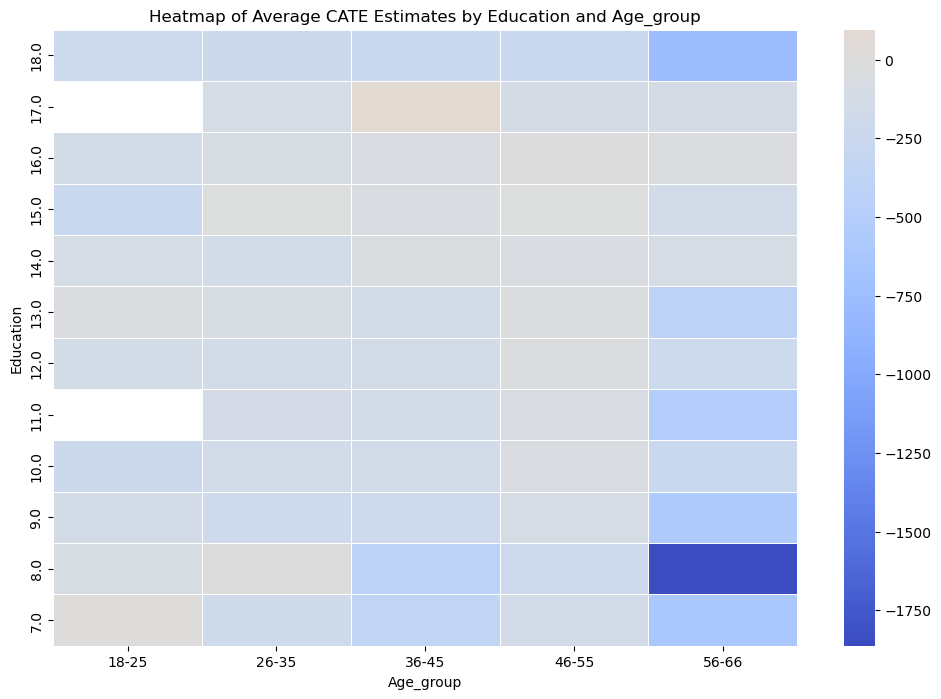

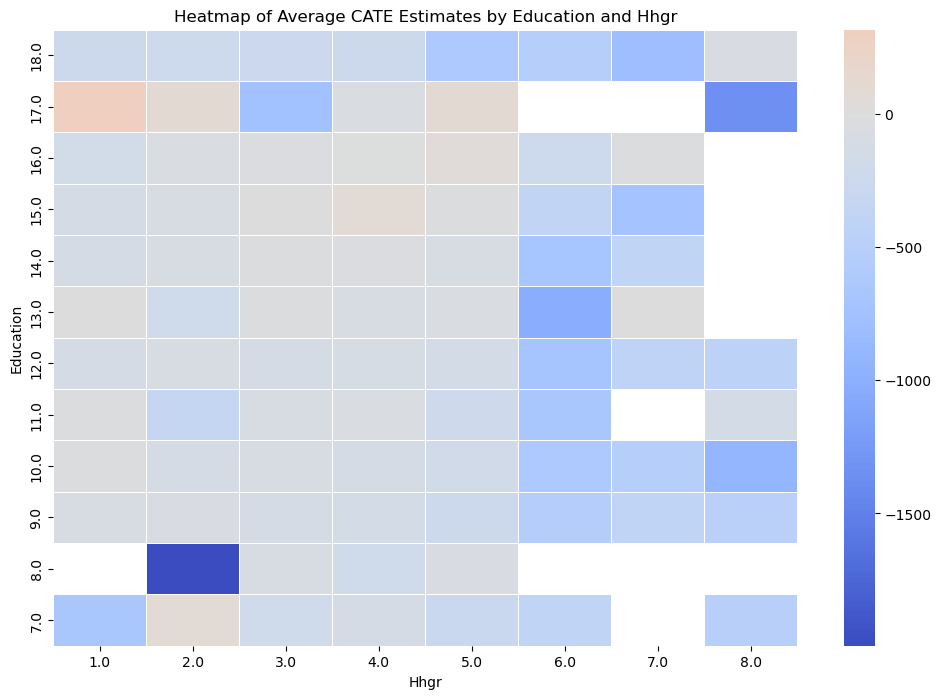

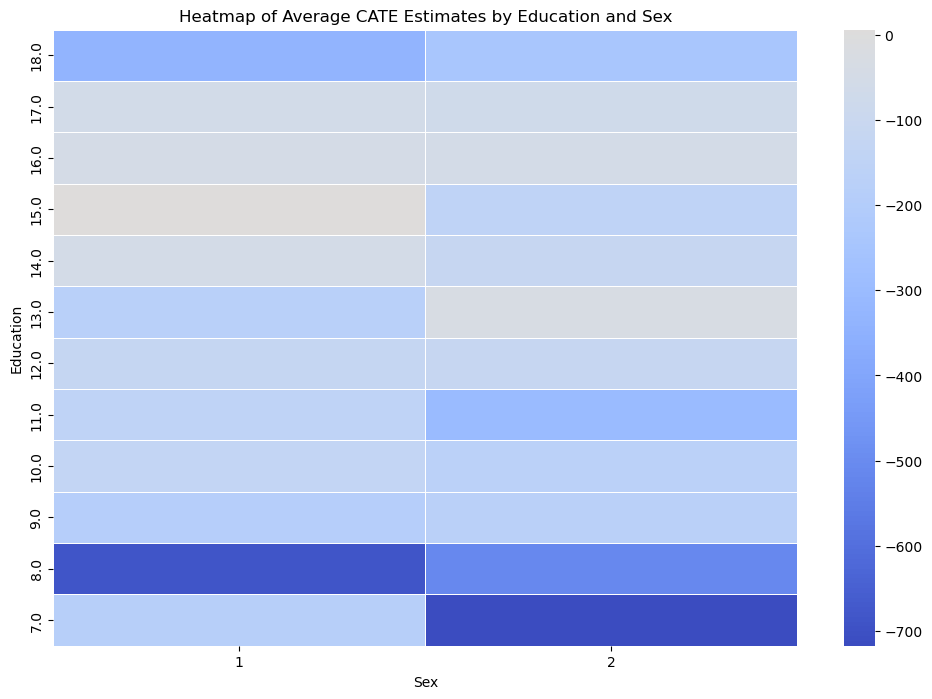

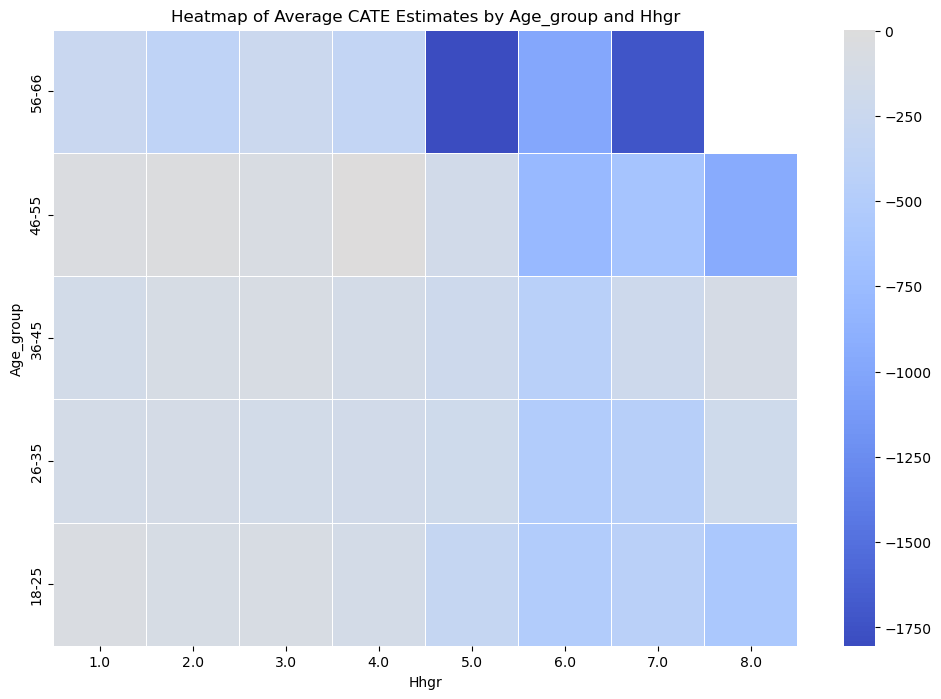

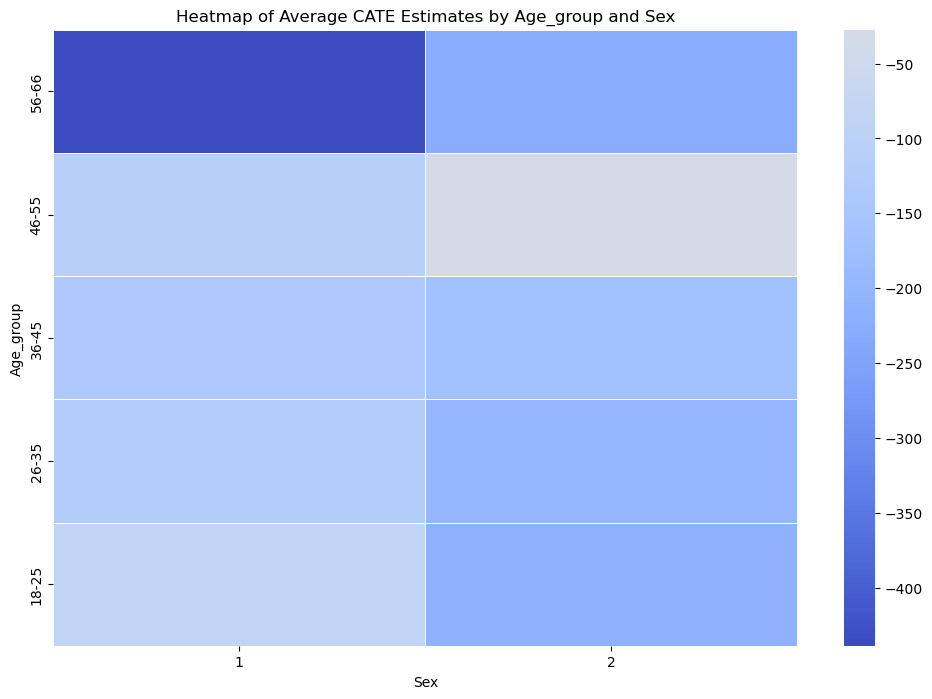

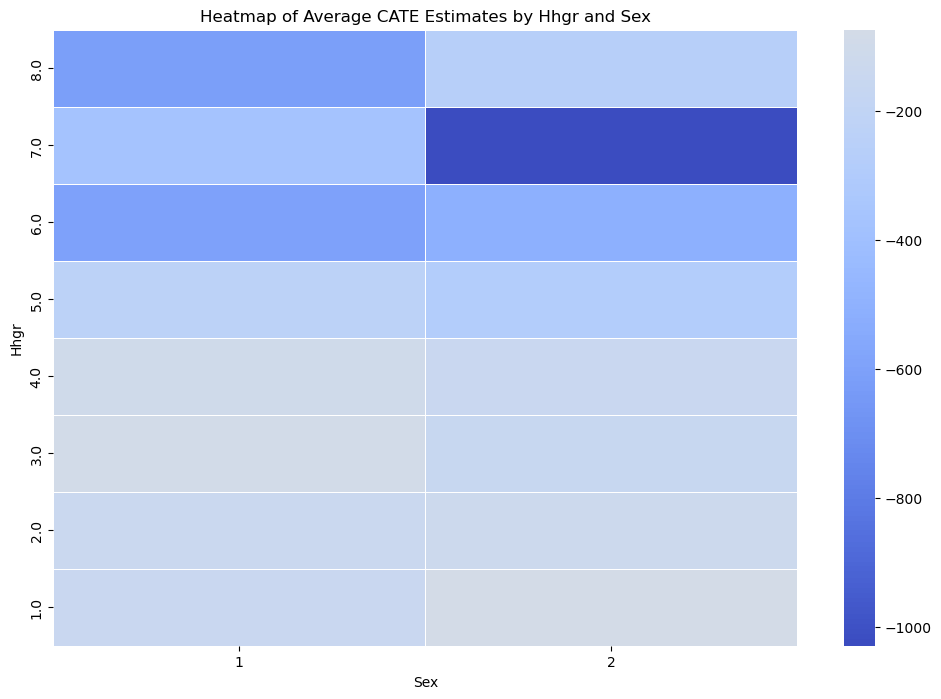

In [23]:
# Plotting Heatmaps for interactions among the subgroups based on CATE estimates for income

# Step 1: Create Age Groups (with ranges suitable for the data)
age_bins = [18, 26, 36, 46, 56, 67]  # Adjusting age bins based on the range 18-66
age_labels = ['18-25', '26-35', '36-45', '46-55', '56-66']
merged_data_clean.loc[:,'age_group'] = pd.cut(merged_data_clean['age_at_survey'], bins=age_bins, labels=age_labels, right=False)

# Step 2: Round Education Levels to the Nearest Whole Number
merged_data_clean.loc[:,'education'] = merged_data_clean['education'].round()

# Step 3: Append CATE Estimates to the DataFrame
merged_data_clean.loc[:,'cate_estimates'] = cate_estimates

# Function to generate heatmap for any pair of covariates
def generate_heatmap(data, covariate1, covariate2):
    # Create a pivot table to aggregate CATE estimates by covariate pair
    heatmap_data = data.pivot_table(index=covariate1, columns=covariate2, values='cate_estimates', aggfunc='mean')

    # Sort the index to ensure proper order
    heatmap_data = heatmap_data.sort_index(ascending=True)

    # Reverse the index to have the values increase from bottom to top if needed
    heatmap_data = heatmap_data[::-1]

    # Generate the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, cmap='coolwarm', center=0, fmt=".2f", linewidths=.5)
    plt.title(f'Heatmap of Average CATE Estimates by {covariate1.capitalize()} and {covariate2.capitalize()}')
    plt.xlabel(covariate2.capitalize())
    plt.ylabel(covariate1.capitalize())
    plt.show()

# Generate heatmaps for combinations of covariates
generate_heatmap(merged_data_clean, 'education', 'age_group')
generate_heatmap(merged_data_clean, 'education', 'hhgr')
generate_heatmap(merged_data_clean, 'education', 'sex')
generate_heatmap(merged_data_clean, 'age_group', 'hhgr')
generate_heatmap(merged_data_clean, 'age_group', 'sex')
generate_heatmap(merged_data_clean, 'hhgr', 'sex')


In [ ]:
# Testing the Significance of the CATE Estimates

# Perform a t-test to see if the mean CATE is significantly different from zero
t_statistic, p_value = stats.ttest_1samp(cate_estimates, 0)

print("t-statistic:", t_statistic)
print("p-value:", p_value)


t-statistic: -4.983861815457811
p-value: 6.410295187120832e-07


In [ ]:
# CONFIDENCE INTERVALS

import numpy as np

# Bootstrap resampling to calculate confidence intervals
n_iterations = 1000
bootstrap_samples = np.random.choice(cate_estimates, size=(n_iterations, len(cate_estimates)), replace=True)
bootstrap_means = np.mean(bootstrap_samples, axis=1)

lower_bound = np.percentile(bootstrap_means, 2.5)
upper_bound = np.percentile(bootstrap_means, 97.5)

print(f"95% Confidence Interval: [{lower_bound}, {upper_bound}]")


95% Confidence Interval: [-52.51086514487639, -22.133632605646294]


In [ ]:
# PERMUTATION TEST

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Increase max_iter for LogisticRegression
propensity_learner = LogisticRegression(random_state=42, max_iter=1000)

# Scale the features
scaler = StandardScaler()
X_clean_scaled = scaler.fit_transform(X_clean)

# Redefine the X-Learner with the updated propensity model and scaled data
x_learner = XLearner(models=outcome_learner, propensity_model=propensity_learner)

# Fit the X-Learner initially with scaled data
x_learner.fit(y_clean, T_clean, X=X_clean_scaled)



In [ ]:
def permutation_test(cate_estimates, T, X, n_permutations=500):
    permuted_cates = []
    for _ in range(n_permutations):
        T_permuted = np.random.permutation(T)
        x_learner.fit(y_clean, T_permuted, X=X)  # Use the scaled features here
        permuted_cate = x_learner.effect(X)
        permuted_cates.append(np.mean(permuted_cate))
    
    observed_mean_cate = np.mean(cate_estimates)
    p_value = np.mean([abs(x) > abs(observed_mean_cate) for x in permuted_cates])
    return observed_mean_cate, p_value

# Run the permutation test with the scaled data
observed_mean_cate, p_value = permutation_test(cate_estimates, T_clean, X_clean_scaled)
print(f"Observed Mean CATE: {observed_mean_cate}")
print(f"Permutation Test p-value: {p_value}")


Observed Mean CATE: -32.08048499145251
Permutation Test p-value: 0.36


In [25]:
# CATE Estimates for Income- Not longitudinal- not scaled on baseline mean income 

# Define the years to calculate the CATE for
years = range(2013, 2021)

# Store results for each year
cate_results = {}

# Loop through each year
for year in years:
    # Filter the income data for the given year
    income_year = income_df[income_df['syear'] == year][['pid', 'gross_income']]
    
    # Merge the income data with the 2011 data based on 'pid'
    merged_data = pd.merge(data_2011, income_year, on='pid', how='inner', suffixes=('_2011', f'_{year}'))
    
    # Drop rows with any missing values
    merged_data_clean = merged_data.dropna(subset=['sex', 'age_at_survey', 'education', 'hhgr', 'gross_income_2011', 'lf_status', 'binary_treatment', f'gross_income_{year}'])
    
    # Define covariates, treatment, and outcome
    X_clean = merged_data_clean[['sex', 'age_at_survey', 'education', 'hhgr', 'gross_income_2011', 'lf_status']]
    T_clean = merged_data_clean['binary_treatment']
    y_clean = merged_data_clean[f'gross_income_{year}']

    # Define the models for the outcome and propensity score estimation
    outcome_learner = GradientBoostingRegressor(n_estimators=100, random_state=42)
    propensity_learner = LogisticRegression(random_state=42, max_iter=1000)
    
    # Instantiate the X-Learner
    x_learner = XLearner(models=outcome_learner, propensity_model=propensity_learner)
    
    # Fit the X-Learner
    x_learner.fit(y_clean, T_clean, X=X_clean)
    
    # Estimate the Conditional Average Treatment Effect (CATE) for the entire dataset
    cate_estimates = x_learner.effect(X_clean)
    
    # Store the results
    cate_results[year] = cate_estimates

    # # Print CATE estimates for the year
    # print(f"CATE Estimates for {year}:")
    # print(cate_estimates)

    # Define a function for bootstrapping
    def bootstrap_cate(X, T, y, x_learner):
        X_resampled, T_resampled, y_resampled = resample(X, T, y)
        x_learner.fit(y_resampled, T_resampled, X=X_resampled)
        return np.mean(x_learner.effect(X_resampled))

    # Parallel bootstrapping
    n_bootstraps = 200  # Adjust this as needed
    bootstrapped_cates = Parallel(n_jobs=-1)(delayed(bootstrap_cate)(X_clean, T_clean, y_clean, x_learner) for _ in range(n_bootstraps))

    # Calculate confidence intervals and standard error
    ci_lower = np.percentile(bootstrapped_cates, 2.5)
    ci_upper = np.percentile(bootstrapped_cates, 97.5)
    std_error = np.std(bootstrapped_cates)

    # print(f"95% Confidence Interval for {year}: [{ci_lower}, {ci_upper}]")
    # print(f"Standard Error for {year}: {std_error}")


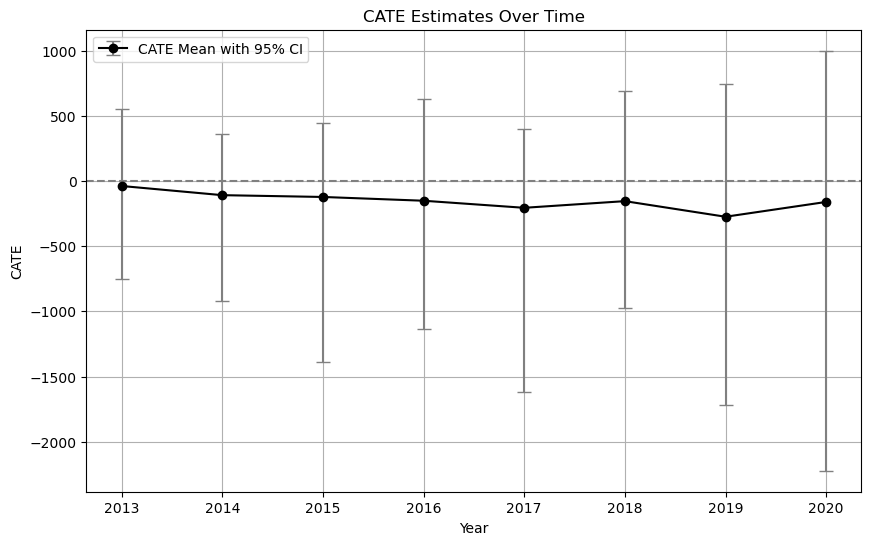

In [ ]:
# Convert to numpy arrays for easier manipulation
years = np.array(list(cate_results.keys()))
mean_cates = np.array([np.mean(cate_results[year]) for year in years])
ci_lower = np.array([np.percentile(cate_results[year], 2.5) for year in years])
ci_upper = np.array([np.percentile(cate_results[year], 97.5) for year in years])

# Plotting with error bars instead of shaded CI
plt.figure(figsize=(10, 6))
plt.errorbar(years, mean_cates, yerr=[mean_cates - ci_lower, ci_upper - mean_cates], fmt='o-', color='black', ecolor='gray', capsize=5, label='CATE Mean with 95% CI')
plt.axhline(0, color='gray', linestyle='--')

plt.xlabel('Year')
plt.ylabel('CATE')
plt.title('CATE Estimates Over Time')
plt.xticks(years)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# trying to model the interactions among sub groups with a different approach

# Example: Interaction between age and education
merged_data_clean['age_education_interaction'] = merged_data_clean['age_at_survey'] * merged_data_clean['education']

# Fit a simple linear model including the interaction term
model = smf.ols('cate_estimates ~ age_at_survey + education + age_education_interaction', data=merged_data_clean).fit()

# Print summary to see the interaction effect
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         cate_estimates   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     9.001
Date:                Fri, 23 Aug 2024   Prob (F-statistic):           6.05e-06
Time:                        00:18:13   Log-Likelihood:                -46065.
No. Observations:                5912   AIC:                         9.214e+04
Df Residuals:                    5908   BIC:                         9.216e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

X does not have valid feature names, but PolynomialFeatures was fitted with feature names


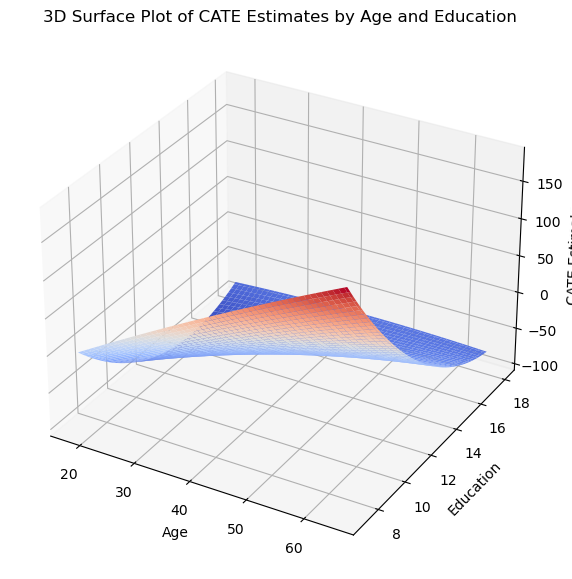

In [ ]:
# age and education interaction plot

# Select relevant columns and drop NaNs
data_subset = merged_data_clean[['age_at_survey', 'education', 'cate_estimates']].dropna()

# Fit a 2nd degree polynomial model to capture potential interaction effects
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(data_subset[['age_at_survey', 'education']])
model = LinearRegression().fit(X_poly, data_subset['cate_estimates'])

# Create a grid of age and education values
age_range = np.linspace(data_subset['age_at_survey'].min(), data_subset['age_at_survey'].max(), 100)
education_range = np.linspace(data_subset['education'].min(), data_subset['education'].max(), 100)
age_grid, education_grid = np.meshgrid(age_range, education_range)

# Predict CATE estimates across the grid
X_grid = poly.transform(np.c_[age_grid.ravel(), education_grid.ravel()])
cate_pred_grid = model.predict(X_grid).reshape(age_grid.shape)

# Plot 3D surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(age_grid, education_grid, cate_pred_grid, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('Age')
ax.set_ylabel('Education')
ax.set_zlabel('CATE Estimate')
ax.set_title('3D Surface Plot of CATE Estimates by Age and Education')
plt.show()


X does not have valid feature names, but PolynomialFeatures was fitted with feature names


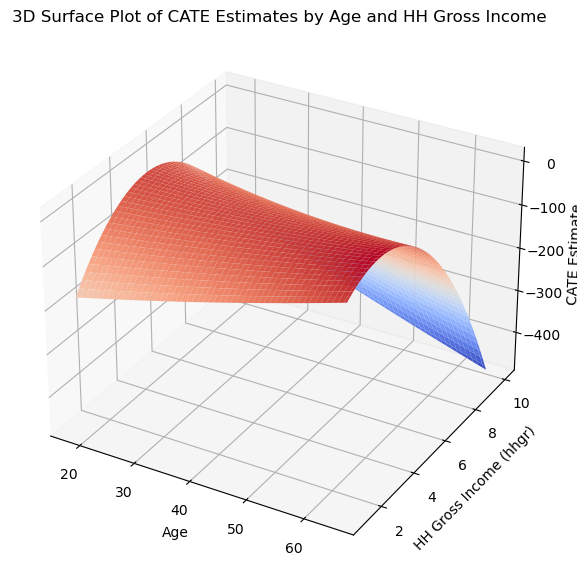

In [ ]:
# age and hhgr interaction plot

# Select relevant columns and drop NaNs
data_subset = merged_data_clean[['age_at_survey', 'hhgr', 'cate_estimates']].dropna()

# Fit a 2nd degree polynomial model to capture potential interaction effects
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(data_subset[['age_at_survey', 'hhgr']])
model = LinearRegression().fit(X_poly, data_subset['cate_estimates'])

# Create a grid of age and hhgr values
age_range = np.linspace(data_subset['age_at_survey'].min(), data_subset['age_at_survey'].max(), 100)
hhgr_range = np.linspace(data_subset['hhgr'].min(), data_subset['hhgr'].max(), 100)
age_grid, hhgr_grid = np.meshgrid(age_range, hhgr_range)

# Predict CATE estimates across the grid
X_grid = poly.transform(np.c_[age_grid.ravel(), hhgr_grid.ravel()])
cate_pred_grid = model.predict(X_grid).reshape(age_grid.shape)

# Plot 3D surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(age_grid, hhgr_grid, cate_pred_grid, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('Age')
ax.set_ylabel('HH Gross Income (hhgr)')
ax.set_zlabel('CATE Estimate')
ax.set_title('3D Surface Plot of CATE Estimates by Age and HH Gross Income')
plt.show()


X does not have valid feature names, but PolynomialFeatures was fitted with feature names


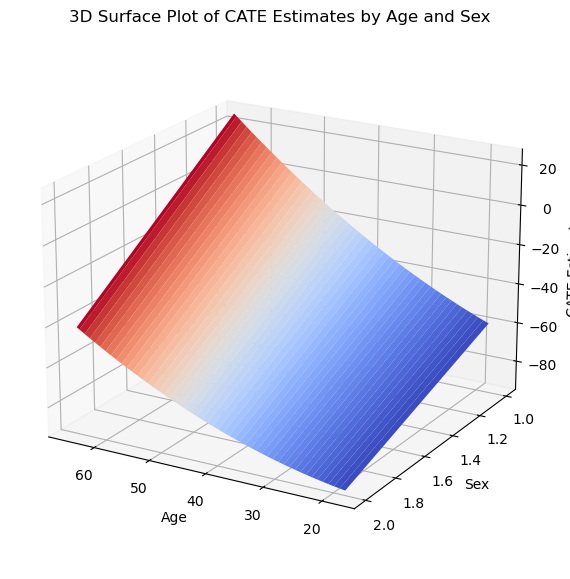

In [ ]:
# age and hhgr interaction plot 

# Select relevant columns and drop NaNs
data_subset = merged_data_clean[['age_at_survey', 'sex', 'cate_estimates']].dropna()

# Fit a 2nd degree polynomial model to capture potential interaction effects
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(data_subset[['age_at_survey', 'sex']])
model = LinearRegression().fit(X_poly, data_subset['cate_estimates'])

# Create a grid of age and sex values
age_range = np.linspace(data_subset['age_at_survey'].min(), data_subset['age_at_survey'].max(), 100)
sex_range = np.array([1, 2])  # Sex is binary: 1 (male) and 2 (female)
age_grid, sex_grid = np.meshgrid(age_range, sex_range)

# Predict CATE estimates across the grid
X_grid = poly.transform(np.c_[age_grid.ravel(), sex_grid.ravel()])
cate_pred_grid = model.predict(X_grid).reshape(age_grid.shape)

# Plot 3D surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(age_grid, sex_grid, cate_pred_grid, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('Age')
ax.set_ylabel('Sex')
ax.set_zlabel('CATE Estimate')
ax.set_title('3D Surface Plot of CATE Estimates by Age and Sex')
ax.view_init(elev=20, azim=120)  # Adjust the viewing angle for better visualization
plt.show()
